# Audio to MIDI Algorithm

In [8]:
import scipy
import matplotlib.pyplot as plt
import numpy as np
import mido

import json
import os

## Audio Data

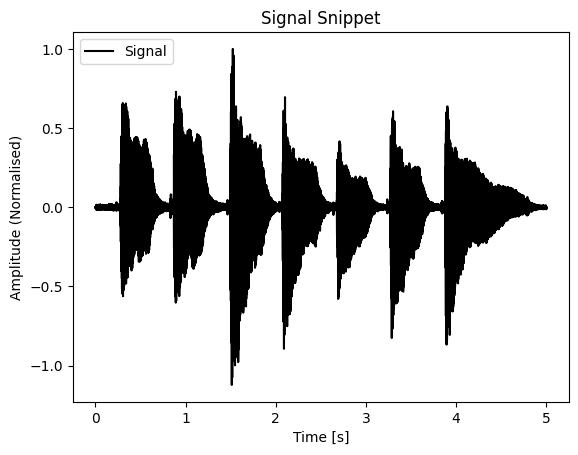

In [3]:
# Opening file,
sample_rate, signal_data = scipy.io.wavfile.read("projectsong.wav")
time_array = np.linspace(0., signal_data.shape[0]/sample_rate, signal_data.shape[0])

# Reading data snippet,
snippet_time, i = 5, 1
time_array, signal_data = time_array[(i - 1)*snippet_time*sample_rate:i*snippet_time*sample_rate], signal_data[(i - 1)*snippet_time*sample_rate:i*snippet_time*sample_rate]

# Averaging channels into one,
signal_data = signal_data.mean(axis = 1)

# Normalising,
signal_data = signal_data/np.max(signal_data)

# Plotting signal,
plt.plot(time_array, signal_data, label = "Signal", color = "black")
plt.title("Signal Snippet")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude (Normalised)")
plt.legend(loc = "upper left")
plt.show()

## Signal STFT

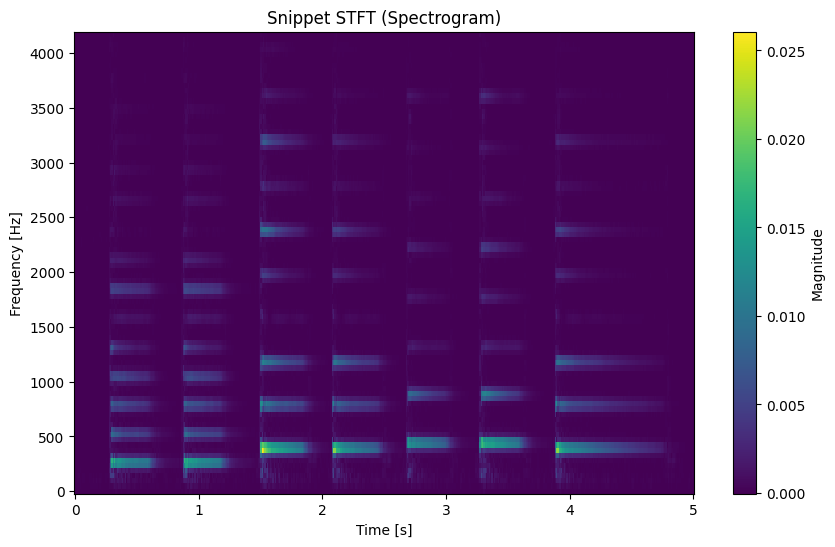

In [7]:
# Parameters,
max_freq = 4200

# Calculate the STFT of the signal
frequencies, times, Zxx = scipy.signal.stft(signal_data, fs = sample_rate, nperseg = 1024, scaling = "psd")
magnitude = np.abs(Zxx)

# Getting rid of frequencies we do not want to consider,
freq_indices = np.where(frequencies <= max_freq)
frequencies = frequencies[freq_indices]
magnitude = magnitude[freq_indices, :][0]

# Reducing overtones and noise,
magnitude = magnitude - np.median(magnitude)

# Plot the STFT magnitude
plt.figure(figsize=(10, 6))
plt.pcolormesh(times, frequencies, magnitude)
plt.title("Snippet STFT (Spectrogram)")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
plt.savefig("Snippet STFT", dpi = 300)
plt.colorbar(label="Magnitude")
plt.show()

## Note Segmentation

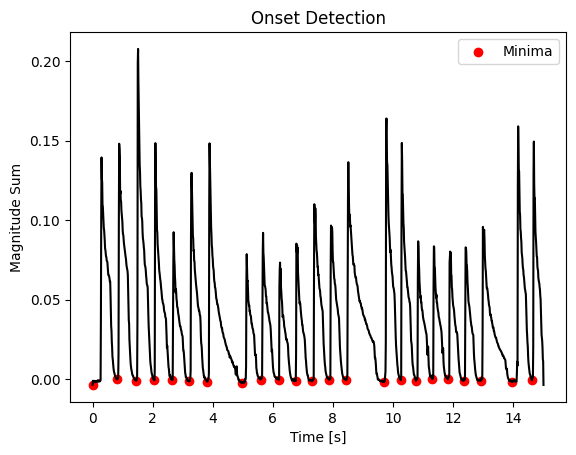

In [37]:
# Summing magntiude for each frequency across time steps,
sums = []
for row in magnitude.T:
    sums.append(np.sum(row))
sums = np.array(sums)

# Finding local minima,
means_inverted = -1*sums
minima_indices, _ = scipy.signal.find_peaks(means_inverted, prominence = 0.05)

# Hard-coding the begining of the first note,
minima_indices = np.insert(minima_indices, 0, 0)

# Segmenting audio into individual notes,
start_times = times[minima_indices]
note_durations = np.diff(start_times)

# Plotting,
plt.plot(times, sums, color = "Black")
plt.scatter(times[minima_indices], sums[minima_indices], color = "red", label = "Minima")
plt.legend(loc = "upper right")
plt.title("Onset Detection")
plt.xlabel("Time [s]")
plt.ylabel("Magnitude Sum")
plt.show()

### View Note STFT

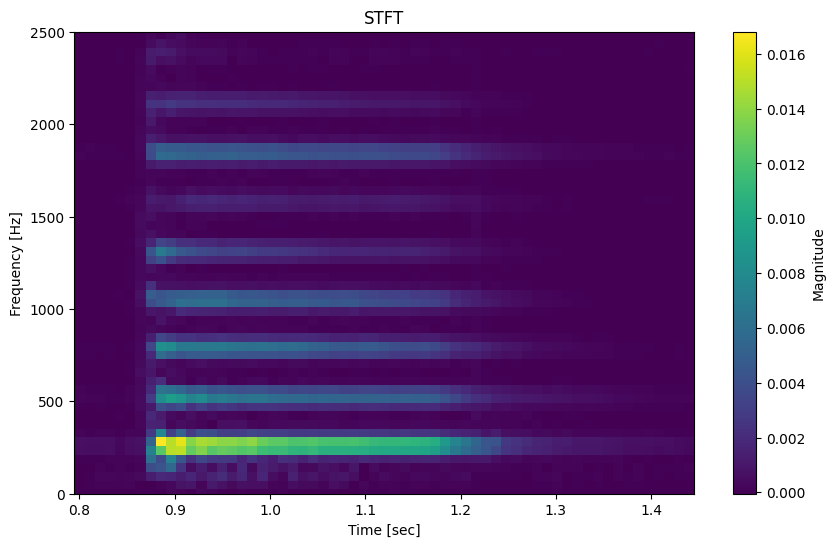

In [38]:
# Plot the STFT magnitude
i = 1
start_index, end_index = minima_indices[i], minima_indices[i+1]
segment_times, segment_magnitude = times[start_index:end_index], magnitude[:, start_index:end_index]

plt.figure(figsize=(10, 6))
plt.pcolormesh(segment_times, frequencies, segment_magnitude)
plt.title("STFT")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [sec]")
plt.colorbar(label="Magnitude")
plt.ylim(0, 2500)
plt.show()

## Detection of Fundamental Frequencies

In [39]:
peak_frequencies = []

# Looping over all note segmentations,
for i in range(len(start_times) - 1):
    start_idx, end_idx = minima_indices[i], minima_indices[i + 1]

    # Corresponding STFT of note segement,
    segment_magnitude = magnitude[:, start_idx:end_idx]

    # Find the location of the peak,
    peak_indices = np.argmax(segment_magnitude)
    peak_frequency_index, peak_time_index = np.unravel_index(peak_indices, segment_magnitude.shape)

    # Extract peak frequency,
    peak_frequency = frequencies[peak_frequency_index]
    peak_frequencies.append(float(peak_frequency))

## Notes Data

In [9]:
notes_data = [
    [0, "N/A", 8.18],
    [1, "N/A", 8.66],
    [2, "N/A", 9.18],
    [3, "N/A", 9.72],
    [4, "N/A", 10.30],
    [5, "N/A", 10.91],
    [6, "N/A", 11.56],
    [7, "N/A", 12.25],
    [8, "N/A", 12.98],
    [9, "N/A", 13.75],
    [10, "N/A", 14.57],
    [11, "N/A", 15.43],
    [12, "N/A", 16.35],
    [13, "N/A", 17.32],
    [14, "N/A", 18.35],
    [15, "N/A", 19.45],
    [16, "N/A", 20.60],
    [17, "N/A", 21.83],
    [18, "N/A", 23.12],
    [19, "N/A", 24.50],
    [20, "N/A", 25.96],
    [21, "A0", 27.50],
    [22, "A#0/Bb0", 29.14],
    [23, "B0", 30.87],
    [24, "C1", 32.70],
    [25, "C#1/Db1", 34.65],
    [26, "D1", 36.71],
    [27, "D#1/Eb1", 38.89],
    [28, "E1", 41.20],
    [29, "F1", 43.65],
    [30, "F#1/Gb1", 46.25],
    [31, "G1", 49.00],
    [32, "G#1/Ab1", 51.91],
    [33, "A1", 55.00],
    [34, "A#1/Bb1", 58.27],
    [35, "B1", 61.74],
    [36, "C2", 65.41],
    [37, "C#2/Db2", 69.30],
    [38, "D2", 73.42],
    [39, "D#2/Eb2", 77.78],
    [40, "E2", 82.41],
    [41, "F2", 87.31],
    [42, "F#2/Gb2", 92.50],
    [43, "G2", 98.00],
    [44, "G#2/Ab2", 103.83],
    [45, "A2", 110.00],
    [46, "A#2/Bb2", 116.54],
    [47, "B2", 123.47],
    [48, "C3", 130.81],
    [49, "C#3/Db3", 138.59],
    [50, "D3", 146.83],
    [51, "D#3/Eb3", 155.56],
    [52, "E3", 164.81],
    [53, "F3", 174.61],
    [54, "F#3/Gb3", 185.00],
    [55, "G3", 196.00],
    [56, "G#3/Ab3", 207.65],
    [57, "A3", 220.00],
    [58, "A#3/Bb3", 233.08],
    [59, "B3", 246.94],
    [60, "C4", 261.63],
    [61, "C#4/Db4", 277.18],
    [62, "D4", 293.66],
    [63, "D#4/Eb4", 311.13],
    [64, "E4", 329.63],
    [65, "F4", 349.23],
    [66, "F#4/Gb4", 369.99],
    [67, "G4", 392.00],
    [68, "G#4/Ab4", 415.30],
    [69, "A4", 440.00],
    [70, "A#4/Bb4", 466.16],
    [71, "B4", 493.88],
    [72, "C5", 523.25],
    [73, "C#5/Db5", 554.37],
    [74, "D5", 587.33],
    [75, "D#5/Eb5", 622.25],
    [76, "E5", 659.26],
    [77, "F5", 698.46],
    [78, "F#5/Gb5", 739.99],
    [79, "G5", 783.99],
    [80, "G#5/Ab5", 830.61],
    [81, "A5", 880.00],
    [82, "A#5/Bb5", 932.33],
    [83, "B5", 987.77],
    [84, "C6", 1046.50],
    [85, "C#6/Db6", 1108.73],
    [86, "D6", 1174.66],
    [87, "D#6/Eb6", 1244.51],
    [88, "E6", 1318.51],
    [89, "F6", 1396.91],
    [90, "F#6/Gb6", 1479.98],
    [91, "G6", 1567.98],
    [92, "G#6/Ab6", 1661.22],
    [93, "A6", 1760.00],
    [94, "A#6/Bb6", 1864.66],
    [95, "B6", 1975.53],
    [96, "C7", 2093.00],
    [97, "C#7/Db7", 2217.46],
    [98, "D7", 2349.32],
    [99, "D#7/Eb7", 2489.02],
    [100, "E7", 2637.02],
    [101, "F7", 2793.83],
    [102, "F#7/Gb7", 2959.96],
    [103, "G7", 3135.96],
    [104, "G#7/Ab7", 3322.44],
    [105, "A7", 3520.00],
    [106, "A#7/Bb7", 3729.31],
    [107, "B7", 3951.07],
    [108, "C8", 4186.01],
    [109, "C#8/Db8", 4434.92],
    [110, "D8", 4698.64],
    [111, "D#8/Eb8", 4978.03],
    [112, "E8", 5274.04],
    [113, "F8", 5587.65],
    [114, "F#8/Gb8", 5919.91],
    [115, "G8", 6271.93],
    [116, "G#8/Ab8", 6644.88],
    [117, "A8", 7040.00],
    [118, "A#8/Bb8", 7458.62],
    [119, "B8", 7902.13],
    [120, "C9", 8372.02],
    [121, "C#9/Db9", 8869.84],
    [122, "D9", 9397.27],
    [123, "D#9/Eb9", 9956.06],
    [124, "E9", 10548.08],
    [125, "F9", 11175.30],
    [126, "F#9/Gb9", 11839.82],
    [127, "G9", 12543.85],
    [128, "G#9/Ab9", 13289.75],
]

## Matching to MIDI Notes

In [40]:
NOTES = []
notes_data = np.array(notes_data)
MIDI_keys, note_names, fundamental_freqs = notes_data.T[0].astype(int), notes_data.T[1], notes_data.T[2].astype(float)

for peak_frequency, note_duration in zip(peak_frequencies, note_durations):
    idx = (np.abs(fundamental_freqs - peak_frequency)).argmin()
    NOTES.append([int(MIDI_keys[idx]), round(float(note_duration), 2)])
    print(f"MIDI Key: {MIDI_keys[idx]}, Note Name: {note_names[idx]}, Frequency (Hz): {fundamental_freqs[idx]}, Duration (s): {round(note_duration, 2)}")

MIDI Key: 61, Note Name: C#4/Db4, Frequency (Hz): 277.18, Duration (s): 0.8
MIDI Key: 61, Note Name: C#4/Db4, Frequency (Hz): 277.18, Duration (s): 0.65
MIDI Key: 66, Note Name: F#4/Gb4, Frequency (Hz): 369.99, Duration (s): 0.61
MIDI Key: 66, Note Name: F#4/Gb4, Frequency (Hz): 369.99, Duration (s): 0.6
MIDI Key: 68, Note Name: G#4/Ab4, Frequency (Hz): 415.3, Duration (s): 0.54
MIDI Key: 68, Note Name: G#4/Ab4, Frequency (Hz): 415.3, Duration (s): 0.62
MIDI Key: 66, Note Name: F#4/Gb4, Frequency (Hz): 369.99, Duration (s): 1.16
MIDI Key: 66, Note Name: F#4/Gb4, Frequency (Hz): 369.99, Duration (s): 0.61
MIDI Key: 64, Note Name: E4, Frequency (Hz): 329.63, Duration (s): 0.62
MIDI Key: 64, Note Name: E4, Frequency (Hz): 329.63, Duration (s): 0.55
MIDI Key: 64, Note Name: E4, Frequency (Hz): 329.63, Duration (s): 0.54
MIDI Key: 61, Note Name: C#4/Db4, Frequency (Hz): 277.18, Duration (s): 0.55
MIDI Key: 61, Note Name: C#4/Db4, Frequency (Hz): 277.18, Duration (s): 0.58
MIDI Key: 58, Note

## Creating Midi File

In [ ]:
# Interfacing with Microsoft GS Wavetable Synth,
port = mido.open_output()
print(port)

In [42]:
# Initialize a new MIDI file and a track
midi = mido.MidiFile()
track = mido.MidiTrack()
midi.tracks.append(track)

# Setting parameters,
velocity = 64
tempo = 500000  
ticks_per_beat = midi.ticks_per_beat
seconds_per_tick = tempo / 1_000_000 / ticks_per_beat

# Add notes to the MIDI track
for note in NOTES:
    midi_key, duration_seconds = note
    duration_ticks = int(duration_seconds / seconds_per_tick)

    # Note on,
    track.append(mido.Message('note_on', note=midi_key, velocity=velocity, time=0))

    # Note off,
    track.append(mido.Message('note_off', note=midi_key, velocity=velocity, time=duration_ticks))

# Save the MIDI file
midi.save("output.mid")

# Full PipeLine